# Информационный поиск (практика)

# Индексирование

Индекс можно строить в базе данных (лучше использовать БД sqlite)

In [208]:
import sqlite3
con=sqlite3.connect('searchindex.db')

Также индекс можно строить в нескольких csv таблицах.

Схема простого индекса состоит из четырёх таблиц. Первая
(urllist) – это список проиндексированных URL. Вторая (wordlist) – список слов, а третья (wordlocation) – список мест вхождения слов в документы. Место вхождения – это номер слова в документе. В таблице link хранятся идентификаторы двух URL, связанных ссылкой. 

В качестве дополнения можно также завести таблицу, в которой хранить текст ссылки (linkwords), мы этого делать не будем.

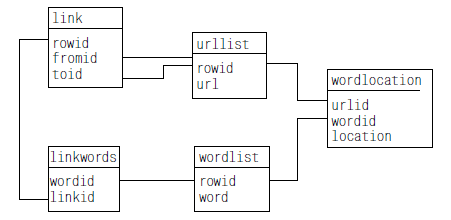

В каждой таблице SQLite по умолчанию имеется поле rowid, поэтому явно задавать ключевые поля необязательно. Если вы используете csv, то нужно будет позаботиться об идентификаторах.

Эта функция создает все нужные нам таблицы, а также ряд индексов, ускоряющих поиск. Индексы необходимы, потому что набор данных может быть очень велик.

In [209]:
def createindextables():
  con.execute('create table urllist(url)')
  con.execute('create table wordlist(word)')
  con.execute('create table wordlocation(urlid,wordid,location)')
  con.execute('create table link(fromid integer,toid integer)')
  con.execute('create index wordidx on wordlist(word)')
  con.execute('create index urlidx on urllist(url)')
  con.execute('create index wordurlidx on wordlocation(wordid)')
  con.execute('create index urltoidx on link(toid)')
  con.execute('create index urlfromidx on link(fromid)')
  con.commit()

In [210]:
createindextables()

# Сбор данных 1 (ссылки)

Вспомним, как можно скачать страницу.

In [183]:
from urllib.request import urlopen
import requests

def download_from_the_internet(url):
    try:
        # return urlopen(url).read().decode('utf-8')
        return requests.get(url, timeout=2).text
    except KeyboardInterrupt:
        raise
    except:
        return None

url = 'https://compscicenter.ru/'
html = download_from_the_internet(url)
# print(html)

Извлечём со страницы все ссылки

In [184]:
from bs4 import BeautifulSoup
from urllib.parse import urljoin

def extract_links_from_html(url, html):
    parser = BeautifulSoup(html)
    return [urljoin(url, link.get('href')) for link in parser.findAll('a')]

links = extract_links_from_html(url, html)
# for link in links:
#     print(link)

Вспомогательная функция `getentryid` возвращает идентификатор записи. Если такой записи еще нет, она создается и возвращается ее идентификатор.

In [185]:
def getentryid(table, field, value):
  cur=con.execute("select rowid from %s where %s='%s'" % (table,field,value))
  res=cur.fetchone( )
  if res==None:
    cur=con.execute("insert into %s (%s) values ('%s')" % (table,field,value))
    return cur.lastrowid
  else:
    return res[0]

Функция `addlinkref` добавляет записи в таблицу `link`

In [186]:
def addlinkref(urlFrom, urlTo):
  fromid=getentryid('urllist','url',urlFrom)
  toid=getentryid('urllist','url',urlTo)
  if fromid==toid: return
  cur=con.execute("insert into link(fromid,toid) values (%d,%d)" % (fromid,toid))

Вызовем эту функцию в цикле:

In [187]:
for link in links:
  addlinkref(url,link)

## Итоговое задание 1

Напишите функцию `crawler`, которая заходит на ресурс и собирает с него ссылки с помощью функции `extract_links_from_html`. Затем функция проходит по всем извлеченным ссылкам (url'ам) и собирает ссылки с этих документов. Все url'ы записываются в таблицу `urllist`. В таблицу `link` записываются пары идентификаторов из таблицу `urllist`, означающие откуда и куда ведёт ссылка. 

Примените crawler не менее чем к трём разным ресурсам примерно одинаковой тематики.

В таблице `link` должно быть не менее 1000 записей.

In [203]:
def add_to_urllist(url):
    try:
        cur = con.execute("insert into urllist(url) values ('%s')" % (url))
    except TypeError:
        return

In [211]:
def crawler(url):
    page_links = extract_links_from_html(url, download_from_the_internet(url))
    links = set()
    links.update(page_links)
    downloaded_urls = {url}
    
    for link in page_links:
        # искуственное ограничение, в реальном мире не нужно
        if len(links) > 1000:
            break

        if link not in downloaded_urls and link.find('.pdf') == -1:
            print(link)
            html = download_from_the_internet(link)
            if html:
                new_links = extract_links_from_html(link, html)
                links.update(new_links)
                downloaded_urls.add(link)
                print('Спарсил страниц: ' + str(len(downloaded_urls)) + '/' + str(len(page_links)))
                print('Количество ссылок: ' + str(len(links)))
            print('–')

    add_to_urllist(url)
    
    for link in links:
        add_to_urllist(link)
        addlinkref(url, link)
        
    return list(links)

In [212]:
# urls = ['https://www.hse.ru/', 'https://www.msu.ru/index.php', 'https://www.spbstu.ru/']
urls = ['https://www.hse.ru/']

In [213]:
links = []

for source in urls:
    links.extend(crawler(source))

https://www.hse.ru/en/cookie.html
Спарсил страниц: 2/258
Количество ссылок: 186
–
https://www.hse.ru/en/data_protection_regulation
Спарсил страниц: 3/258
Количество ссылок: 192
–
http://nnov.hse.ru/en/
Спарсил страниц: 4/258
Количество ссылок: 234
–
http://spb.hse.ru/en/
Спарсил страниц: 5/258
Количество ссылок: 332
–
http://perm.hse.ru/en/
Спарсил страниц: 6/258
Количество ссылок: 382
–
https://www.hse.ru/en/minecraft/
Спарсил страниц: 7/258
Количество ссылок: 409
–
https://admissions.hse.ru/cn/
Спарсил страниц: 8/258
Количество ссылок: 538
–
https://www.hse.ru/en/
Спарсил страниц: 9/258
Количество ссылок: 538
–
https://www.hse.ru/en/user/
Спарсил страниц: 10/258
Количество ссылок: 540
–
https://www.hse.ru/search/search.html?simple=0
Спарсил страниц: 11/258
Количество ссылок: 611
–
https://www.hse.ru/en/info/
Спарсил страниц: 12/258
Количество ссылок: 642
–
http://www.hse.ru/en/figures/
Спарсил страниц: 13/258
Количество ссылок: 671
–
https://strategy.hse.ru/en/rating/
Спарсил страниц

In [214]:
con.execute('select count(*) from link').fetchone()

(1089,)

# Сбор данных 2 (слова)

Этот код формирует длинную строку, содержащую весь имеющийся на странице текст. А затем разделяет его на слова и нормализует.

In [215]:
import re

In [216]:
def gettextonly(html):
  if not html:
    return None

  text = BeautifulSoup(html).get_text()
  text = re.sub("[^а-яА-Я]", " ", text) # для русскоязычных текстов оставляем только буквенные символы
  return text

In [217]:
print (gettextonly(html))

                                                                Направления  Курсы  Онлайн образование  Поступление  О центре      Войти                 Направления Курсы Онлайн образование   Онлайн курсы Онлайн программы Видеозаписи лекций  Поступление   Подать заявку Памятка Программа для поступления Вопросы и ответы  О центре   История Команда Преподаватели Выпускники Отзывы       Знания  востребованные в науке и индустрии              Очные вечерние курсы в Санкт Петербурге и в Новосибирске по тр м направлениям                                                                    Онлайн курсы для жителей других городов            Смотреть программы Узнать о центре      Очные курсы центра                  Центр приглашает молодых специалистов  аспирантов  студентов средних и старших курсов технических специальностей пройти двух  или тр хлетние курсы по направлениям                                        Разработка программного обеспечения                   Анализ данных                

In [48]:
!pip install pymorphy2

  Using cached pymorphy2-0.9.1-py3-none-any.whl (55 kB)
  Using cached pymorphy2_dicts_ru-2.4.417127.4579844-py2.py3-none-any.whl (8.2 MB)
  Using cached docopt-0.6.2.tar.gz (25 kB)
  Using cached DAWG_Python-0.7.2-py2.py3-none-any.whl (11 kB)
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=439c915a20341681d2c96d9671230039f3924b89927eb7b225afaf9d93169881
  Stored in directory: /Users/fowku/Library/Caches/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [218]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

In [219]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords # стоп-слова из NLTK

[nltk_data] Downloading package stopwords to /Users/fowku/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [220]:
ignorewords = stopwords.words('russian')

In [221]:
def separatewords(text):
  words = text.lower().split()
  words_normalized = []

  for word in words:
    lemma = pymorphy2_analyzer.parse(word)
    words_normalized.append(lemma[0].normal_form)

  words_normalized = [word for word in words_normalized if len(word) > 1 and word not in ignorewords]
  
  return words_normalized

In [222]:
print (separatewords(gettextonly(html)))

['направление', 'курс', 'онлайн', 'образование', 'поступление', 'центр', 'войти', 'направление', 'курс', 'онлайн', 'образование', 'онлайн', 'курс', 'онлайн', 'программа', 'видеозапись', 'лекция', 'поступление', 'подать', 'заявка', 'памятка', 'программа', 'поступление', 'вопрос', 'ответ', 'центр', 'история', 'команда', 'преподаватель', 'выпускник', 'отзыв', 'знание', 'востребовать', 'наука', 'индустрия', 'очный', 'вечерний', 'курс', 'санкт', 'петербург', 'новосибирск', 'тр', 'направление', 'онлайн', 'курс', 'житель', 'город', 'смотреть', 'программа', 'узнать', 'центр', 'очный', 'курс', 'центр', 'центр', 'приглашать', 'молодой', 'специалист', 'аспирант', 'студент', 'средний', 'старший', 'курс', 'технический', 'специальность', 'пройти', 'тр', 'хлетний', 'курс', 'направление', 'разработка', 'программный', 'обеспечение', 'анализ', 'данные', 'современный', 'информатика', 'центр', 'существовать', 'дать', 'возможность', 'талантливый', 'студент', 'выпускник', 'развиваться', 'интересный', 'напра

## Итоговое задание 2

Протестируйте функции `gettextonly` и `separatewords`. При необходимости доработайте. Результат функции `separatewords` нужно записать в таблицу `wordlist`.

In [225]:
words = []

for i, link in enumerate(links):
    print(f'{str(i)}/{len(links)}')
    text = gettextonly(download_from_the_internet(link))

    if text:
        page_words = separatewords(text)
        words.extend(page_words)

0/1090
1/1090
2/1090
3/1090
4/1090
5/1090
6/1090
7/1090
8/1090
9/1090
10/1090
11/1090
12/1090
13/1090
14/1090
15/1090
16/1090
17/1090
18/1090
19/1090
20/1090
21/1090
22/1090
23/1090
24/1090
25/1090
26/1090
27/1090
28/1090
29/1090
30/1090
31/1090
32/1090
33/1090
34/1090
35/1090
36/1090
37/1090
38/1090
39/1090
40/1090
41/1090
42/1090
43/1090
44/1090
45/1090
46/1090
47/1090
48/1090
49/1090
50/1090
51/1090
52/1090
53/1090
54/1090
55/1090
56/1090
57/1090
58/1090
59/1090
60/1090
61/1090
62/1090
63/1090
64/1090
65/1090
66/1090
67/1090
68/1090
69/1090
70/1090
71/1090
72/1090
73/1090
74/1090
75/1090
76/1090
77/1090
78/1090
79/1090
80/1090
81/1090
82/1090
83/1090
84/1090
85/1090
86/1090
87/1090
88/1090
89/1090
90/1090
91/1090
92/1090
93/1090
94/1090
95/1090
96/1090
97/1090
98/1090
99/1090
100/1090
101/1090
102/1090
103/1090
104/1090
105/1090
106/1090
107/1090
108/1090
109/1090
110/1090
111/1090
112/1090
113/1090
114/1090
115/1090
116/1090
117/1090
118/1090
119/1090
120/1090
121/1090
122/1090
123

In [226]:
for word in words:
    cur = con.execute('insert into wordlist(word) values(\'%s\')' % (word))

In [227]:
con.execute('select count(*) from wordlist').fetchone()

(124905,)

# Добавление в индекс

Код функции `isindexed`, которая определяет, есть ли указанная страница в базе данных и, если да, ассоциированы ли с ней какие-нибудь слова

In [228]:
def isindexed(url):
    u=con.execute ("select rowid from urllist where url='%s'" % url).fetchone()
    if u!=None:
      v= con.execute('select * from wordlocation where urlid=%d' % u[0]).fetchone()
      if v!=None: return True
    return False

Код функции `addtoindex` вызывает функции, написанные ранее, чтобы получить список слов на странице. Затем эта страница и все найденные на ней слова добавляются в индекс и создаются ссылки между словами и их вхождениями
в документ. В нашем примере адресом вхождения будет считаться номер слова в списке слов.

In [229]:
def addtoindex(url):
  if isindexed(url): return
  print ('Индексируется %s' % url)

  html = download_from_the_internet(url)

  if html:
    # Получить список слов
    words = separatewords (gettextonly(html))

    # Получить идентификатор URL
    urlid = getentryid('urllist','url',url)

    # Связать каждое слово с этим URL
    for i in range(len(words)):
      word=words[i]
      if word in ignorewords: continue # здесь учтены стоп-слова, но не учтены однобуквенные слова
      wordid = getentryid('wordlist', 'word', word)
      con.execute("insert into wordlocation(urlid,wordid,location) values (%d,%d,%d)" % (urlid,wordid,i))

In [230]:
addtoindex(url)

Индексируется https://compscicenter.ru/


Протестируем написанные функции:

In [231]:
getentryid('wordlist', 'word', 'программирование')

2314

In [232]:
cur=con.execute("select rowid from %s where %s='%s'" % ('wordlist','word', 'программирование'))
res=cur.fetchone( )

In [233]:
print (res)

(2314,)


In [234]:
cur=con.execute("select word from %s where %s='%s'" % ('wordlist','rowid', 73))
res=cur.fetchone( )

In [235]:
print (res)

('современный',)


In [236]:
[row for row in con.execute('select word from wordlist')]

[('широта',),
 ('далее',),
 ('широта',),
 ('старый',),
 ('версия',),
 ('браузер',),
 ('сайт',),
 ('мочь',),
 ('отображаться',),
 ('некорректно',),
 ('оптимальный',),
 ('работа',),
 ('сайт',),
 ('рекомендовать',),
 ('воспользоваться',),
 ('современный',),
 ('браузер',),
 ('старый',),
 ('версия',),
 ('браузер',),
 ('сайт',),
 ('мочь',),
 ('отображаться',),
 ('некорректно',),
 ('оптимальный',),
 ('работа',),
 ('сайт',),
 ('рекомендовать',),
 ('воспользоваться',),
 ('современный',),
 ('браузер',),
 ('старый',),
 ('версия',),
 ('браузер',),
 ('сайт',),
 ('мочь',),
 ('отображаться',),
 ('некорректно',),
 ('оптимальный',),
 ('работа',),
 ('сайт',),
 ('рекомендовать',),
 ('воспользоваться',),
 ('современный',),
 ('браузер',),
 ('старый',),
 ('версия',),
 ('браузер',),
 ('сайт',),
 ('мочь',),
 ('отображаться',),
 ('некорректно',),
 ('оптимальный',),
 ('работа',),
 ('сайт',),
 ('рекомендовать',),
 ('воспользоваться',),
 ('современный',),
 ('браузер',),
 ('ааааа',),
 ('старый',),
 ('версия',),
 (

In [237]:
[row for row in con.execute('select rowid from wordlocation where wordid=73')]

[]

In [238]:
[row for row in con.execute('select url from urllist')]

,
 ('https://perm.hse.ru/en/education/',),
 ('https://admissions.hse.ru/cn/russian-language-apply',),
 ('https://www.hse.ru/international/semester/',),
 ('https://admissions.hse.ru/en/news/tags/online/',),
 ('https://careerspace.hse.ru/',),
 ('https://library.hse.ru/',),
 ('https://www.instagram.com/vandervetrov/',),
 ('https://www.facebook.com/infohseindonesia/',),
 ('https://spb.hse.ru/en/announcements/428156698.html',),
 ('https://perm.hse.ru/en/news/community/',),
 ('https://ba.hse.ru/',),
 ('https://www.hse.ru/en/info/distinguished/',),
 ('https://www.hse.ru/en/ma/mdt/',),
 ('https://admissions.hse.ru/',),
 ('https://design.hse.ru/ba/program/fashion',),
 ('https://www.hse.ru/recommends',),
 ('https://pay.hse.ru/',),
 ('http://spb.hse.ru/en/info/',),
 ('https://www.hse.ru/en/ba/data/',),
 ('https://www.weibo.com/hseuniversity',),
 ('https://perm.hse.ru/en/admissions/',),
 ('https://www.hse.ru/en/news/keywords/34648636/',),
 ('https://www.hse.ru/en/ma/langart/',),
 ('https://nnov.hs

## Итоговое задание 3

Пока мы проиндексировали только одну страницу. Доработайте написанную ранее функцию `crawler`, дополнив её написанными ранее функции для построения индекса. Не забывайте, что в индекс не нужно включать однобуквенные слова и стоп-слова. 



In [ ]:
def crawler(url):
    page_links = extract_links_from_html(url, download_from_the_internet(url))
    links = set()
    links.update(page_links)
    downloaded_urls = {url}
    
    for link in page_links:
        # искуственное ограничение, в реальном мире не нужно
        if len(links) > 1000:
            break

        if link not in downloaded_urls and link.find('.pdf') == -1:
            print(link)
            html = download_from_the_internet(link)
            if html:
                new_links = extract_links_from_html(link, html)
                links.update(new_links)
                downloaded_urls.add(link)
                print('Спарсил страниц: ' + str(len(downloaded_urls)) + '/' + str(len(page_links)))
                print('Количество ссылок: ' + str(len(links)))
            print('–')

    add_to_urllist(url)
    
    for link in links:
        add_to_urllist(link)
        addlinkref(url, link)
        addtoindex(link)
        
    return list(links)

In [239]:
for url in urls:
  crawler(url)

In [242]:
# для оптимизации, чтобы заново не парсить ссылки
# в общем случае можно просто вызывать crawler()
for i, link in enumerate(links):
    addtoindex(link)
    print(f'{i}/{len(links)}')
    print('–')

issions/exchange-apply
779/1090
–
Индексируется https://www.hse.ru/en/news/keywords/147267563/
780/1090
–
Индексируется https://strategy.hse.ru/en/about5-100
781/1090
–
Индексируется https://strategy.hse.ru/en/rating/#THEsubj
782/1090
–
Индексируется https://www.instagram.com/p/Bnt-fjPBS1A/?utm_source=ig_share_sheet&igshid=bpfk5kyzf9q1
783/1090
–
Индексируется https://www.hse.ru/minecraft/
784/1090
–
Индексируется https://www.hse.ru/international/summer/
785/1090
–
Индексируется https://wa.me/79163118521?utm_source=admissions2020&utm_medium=whatsapp&utm_campaign=calls
786/1090
–
Индексируется https://www.hse.ru/en/ma/finmarket/
787/1090
–
Индексируется https://www.hse.ru/en/sumschool/
788/1090
–
Индексируется mailto:press@hse.ru
789/1090
–
Индексируется https://www.hse.ru/en/news/announcements/subscribe/135083/
790/1090
–
Индексируется https://www.instagram.com/p/B3xqT_Bn_a5/?igshid=vneczgogl4k6
791/1090
–
Индексируется http://nnov.hse.ru/en/intnn/city
792/1090
–
Индексируется https://

In [245]:
con.execute("select count(*) from wordlocation").fetchone()

(126514,)

# Поисковые запросы

Теперь у нас есть работающий паук и большой набор проиндексированных документов, и мы готовы приступить к реализации той части поисковой машины, которая выполняет поиск.

Таблица `wordlocation` обеспечивает простой способ связать слова с документами, так что мы можем легко найти, какие страницы содержат данное слово. Однако поисковая машина была бы довольно слабой, если бы не позволяла задавать запросы с несколькими словами. Чтобы исправить это упущение, нам понадобится функция, которая принимает строку запроса, разбивает ее на слова и строит SQL-запрос для поиска URL тех документов, в которые входят все указанные слова.

In [246]:
def getmatchrows(q):
    # заведём строки для дальнейшего формирования запроса
    fieldlist='w0.urlid'
    tablelist=''
    clauselist=''

    wordids=[]

    # разобъём запрос на отдельные слова
    words=separatewords(q)
    tablenumber=0

    for word in words:
      # получим ID слова из запроса
      wordrow=con.execute("select rowid from wordlist where word='%s'" % word).fetchone()
      if wordrow!=None:
        wordid=wordrow[0]
        wordids.append(wordid)

        if tablenumber>0: # это для случаев, когда в запросе более одного слова
          tablelist+=','
          clauselist+=' and '
          clauselist+='w%d.urlid=w%d.urlid and ' % (tablenumber-1,tablenumber)
          
        fieldlist+=',w%d.location' % tablenumber
        tablelist+='wordlocation w%d' % tablenumber
        clauselist+='w%d.wordid=%d' % (tablenumber,wordid)
        tablenumber+=1

    # сформировать запрос в базу
    fullquery='select %s from %s where %s' % (fieldlist,tablelist,clauselist)
    cur=con.execute(fullquery)
    rows=[row for row in cur]

    return rows,wordids

In [247]:
getmatchrows('обучение программированию')

([(1092, 98, 120),
  (1092, 175, 120),
  (1092, 351, 120),
  (1092, 388, 120),
  (23, 312, 288),
  (23, 312, 294),
  (23, 355, 288),
  (23, 355, 294),
  (23, 442, 288),
  (23, 442, 294),
  (23, 611, 288),
  (23, 611, 294),
  (147, 320, 3076),
  (147, 320, 3079),
  (147, 320, 5547),
  (147, 320, 5568),
  (147, 320, 7173),
  (147, 320, 7179),
  (147, 320, 7198),
  (147, 320, 8193),
  (147, 320, 8196),
  (147, 399, 3076),
  (147, 399, 3079),
  (147, 399, 5547),
  (147, 399, 5568),
  (147, 399, 7173),
  (147, 399, 7179),
  (147, 399, 7198),
  (147, 399, 8193),
  (147, 399, 8196),
  (147, 933, 3076),
  (147, 933, 3079),
  (147, 933, 5547),
  (147, 933, 5568),
  (147, 933, 7173),
  (147, 933, 7179),
  (147, 933, 7198),
  (147, 933, 8193),
  (147, 933, 8196),
  (147, 2873, 3076),
  (147, 2873, 3079),
  (147, 2873, 5547),
  (147, 2873, 5568),
  (147, 2873, 7173),
  (147, 2873, 7179),
  (147, 2873, 7198),
  (147, 2873, 8193),
  (147, 2873, 8196),
  (147, 3060, 3076),
  (147, 3060, 3079),
  (147

В ответе у нас первым идёт id документа, затем позиция первого слова из запроса, позиция второго слова из запроса и так для каждого вхождения. Затем отдельный список с id слов из запроса.

In [248]:
getmatchrows('объектно-ориентированная музыка')

([(97, 426),
  (114, 1200),
  (114, 1701),
  (387, 94),
  (707, 2329),
  (707, 2358),
  (721, 2105)],
 [9552])

У нас нет обработки запросов, в которых только слова, которых нет в индексе:

In [ ]:
# getmatchrows('музыка')

Дополним наш индекс вторым документом.

In [ ]:
url = 'https://yandexdataschool.ru/' # этот url уже есть в таблице urllist

In [ ]:
addtoindex(url)

Индексируется https://yandexdataschool.ru/


Повторим запрос для "программирование" и увидим, что вхождений стало больше.

In [ ]:
[row for row in con.execute('select rowid from wordlocation where wordid=73')]

[(113,), (119,), (1473,), (1495,), (2409,), (2431,)]

In [ ]:
getmatchrows('программирование')

([(1, 139), (1, 146), (24, 1334), (24, 1368), (24, 2559), (24, 2593)], [73])

In [ ]:
getmatchrows('обучение программированию')

([(1, 122, 139),
  (1, 122, 146),
  (1, 229, 139),
  (1, 229, 146),
  (24, 32, 1334),
  (24, 32, 1368),
  (24, 32, 2559),
  (24, 32, 2593),
  (24, 77, 1334),
  (24, 77, 1368),
  (24, 77, 2559),
  (24, 77, 2593),
  (24, 281, 1334),
  (24, 281, 1368),
  (24, 281, 2559),
  (24, 281, 2593),
  (24, 303, 1334),
  (24, 303, 1368),
  (24, 303, 2559),
  (24, 303, 2593),
  (24, 329, 1334),
  (24, 329, 1368),
  (24, 329, 2559),
  (24, 329, 2593),
  (24, 387, 1334),
  (24, 387, 1368),
  (24, 387, 2559),
  (24, 387, 2593),
  (24, 529, 1334),
  (24, 529, 1368),
  (24, 529, 2559),
  (24, 529, 2593),
  (24, 596, 1334),
  (24, 596, 1368),
  (24, 596, 2559),
  (24, 596, 2593),
  (24, 602, 1334),
  (24, 602, 1368),
  (24, 602, 2559),
  (24, 602, 2593),
  (24, 650, 1334),
  (24, 650, 1368),
  (24, 650, 2559),
  (24, 650, 2593),
  (24, 702, 1334),
  (24, 702, 1368),
  (24, 702, 2559),
  (24, 702, 2593),
  (24, 762, 1334),
  (24, 762, 1368),
  (24, 762, 2559),
  (24, 762, 2593),
  (24, 963, 1334),
  (24, 96

In [ ]:
getmatchrows('объектно-ориентированное программирование')

([(1, 139), (1, 146), (24, 1334), (24, 1368), (24, 2559), (24, 2593)], [73])

Напомним некоторые факты про word2vec

In [251]:
import urllib.request
import gensim # библиотека для загрузки и использвоания моделй w2v
from gensim.models import word2vec # непосредственно методы w2v

In [252]:
# скачиваем модель ruscorpora_mystem_cbow_300 с сайта rusvectores
# там есть и другие модели https://rusvectores.org/ru/models/
# 300 - размерность вектора embeddings для слов

urllib.request.urlretrieve("http://rusvectores.org/static/models/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz", "ruscorpora_mystem_cbow_300_2_2015.bin.gz")

('ruscorpora_mystem_cbow_300_2_2015.bin.gz',
 <http.client.HTTPMessage at 0x7f90426622b0>)

In [253]:
# загружаем модель

model_path = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

model_ru = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [254]:
model_ru.most_similar(positive=['обучение_S'], topn=10)

[('преподавание_S', 0.5784180164337158),
 ('подготовка_S', 0.5417913198471069),
 ('учеба_S', 0.5410639047622681),
 ('обучаться_V', 0.520355224609375),
 ('обучать_V', 0.517339825630188),
 ('воспитание_S', 0.49876710772514343),
 ('занятие_S', 0.4969741404056549),
 ('профориентация_S', 0.47712472081184387),
 ('школа_S', 0.47171083092689514),
 ('переподготовка_S', 0.47077974677085876)]

## Итоговое задание 4

Доработайте `getmatchrows` так, чтобы обрабатывалась ситуация, когда вводится слова, которых нет в индексе. 

Попробуйте доработать так, что учитывались не только слова запроса, но и "похожие" на них слова. Для этого можно взять модель с `rusvectores`. Желательно эту модель дообучить.

Про добучение было тут: https://colab.research.google.com/drive/1qNXv_GzDzMxqhzu-N2S2grEhkKHwwoRy#scrollTo=sV2bGBFTmT0z

In [280]:
import itertools

def get_similar_request(q):
    try:
        result =[[] for _ in range(len(q.split(' ')))]
      
        for i, word in enumerate(q.split(' ')):
            p = pymorphy2_analyzer.parse(word)[0]
            pos = p.tag.POS[0]
            if pos == 'N':
                pos = 'S'

            try:
                similar = [x[0] for x in model_ru.most_similar(positive=[f'{word}_{pos}'], topn=3)]
                result[i] = [w.split('_')[0] for w in similar]
            except KeyError:
                result[i] = [word]

        all_permuts = list(map(' '.join, itertools.chain(itertools.product(*result))))
        all_permuts.append(q)
    
    except:
        print(q)
        return [q]

    return all_permuts

In [281]:
get_similar_request('образование школа')

['послевузовский гимназия',
 'послевузовский училище',
 'послевузовский курсы',
 'школа гимназия',
 'школа училище',
 'школа курсы',
 'просвещение гимназия',
 'просвещение училище',
 'просвещение курсы',
 'образование школа']

In [262]:
def get_match_rows(q):
    # заведём строки для дальнейшего формирования запроса
    fieldlist = 'w0.urlid'
    tablelist = ''
    clauselist = ''

    wordids = []

    # разобъём запрос на отдельные слова
    words = separatewords(q)
    tablenumber = 0

    for word in words:
      # получим ID слова из запроса
      wordrow = con.execute("select rowid from wordlist where word='%s'" % word.strip()).fetchone()
      if wordrow != None:
        wordid = wordrow[0]
        wordids.append(wordid)

        if tablenumber > 0: # это для случаев, когда в запросе более одного слова
          tablelist += ','
          clauselist += ' and '
          clauselist += 'w%d.urlid=w%d.urlid and ' % (tablenumber-1,tablenumber)
          
        fieldlist += ',w%d.location' % tablenumber
        tablelist += 'wordlocation w%d' % tablenumber
        clauselist += 'w%d.wordid=%d' % (tablenumber,wordid)
        tablenumber += 1
      else:
        print(f'Нет резултатов для запроса: {q}')
        return

    # сформировать запрос в базу
    fullquery = 'select %s from %s where %s' % (fieldlist, tablelist, clauselist)
    cur = con.execute(fullquery)
    rows = [row for row in cur]

    return rows, wordids

def getmatchrows(q):
  similar_request = get_similar_request(q)

  for request in similar_request:
    return get_match_rows(request)

In [265]:
getmatchrows('кафедра учеба')

([(51, 600, 969),
  (114, 304, 1709),
  (114, 352, 1709),
  (114, 382, 1709),
  (114, 385, 1709),
  (114, 580, 1709),
  (114, 629, 1709),
  (204, 247, 293),
  (204, 247, 388),
  (204, 247, 420),
  (204, 247, 450),
  (204, 247, 572),
  (204, 247, 596),
  (204, 247, 675),
  (204, 247, 721),
  (204, 247, 735),
  (204, 247, 739),
  (204, 247, 930),
  (293, 851, 176),
  (700, 585, 849),
  (713, 368, 176),
  (713, 368, 456),
  (713, 368, 466),
  (713, 368, 476),
  (713, 572, 176),
  (713, 572, 456),
  (713, 572, 466),
  (713, 572, 476),
  (721, 2779, 1212),
  (721, 2779, 1609),
  (721, 2779, 2327),
  (1062, 294, 201)],
 [207, 6663])

# Ранжирование по содержимому

Пока что наша функция находит страницы, соответствующие словам запроса. Но выдача реализована в том порядке, в котором страницы посещались пауком. На практике это только лишь сужает круг интересующих документов. Необходимо как-то присвоить страницам **ранг** относительно данного запроса и возвращать их в порядке убывания рангов. Это и есть ранжирование.

Есть несколько способов вычисления ранга на основе самого запроса и содержимого страницы, а именно:
* частота слов (количество вхождений в документ слова, указанного в запросе, помогает определить степень релевантности документа)
* расстояние между словами (если в запросе несколько слов, то они должны встречаться в документе рядом)
* расположение в документе (предположение: основная тема документа, скорее всего, раскрывается ближе к его началу)

Ранжирование по содержимому в веб-поиске даёт не всегда хороший результат, его можно улучшить результат, принимая во внимание, например количество и качество указывающих на нее ссылок. Как раз таким улучшением является алгоритм PageRank.

Вспомогательная функция для нормализации. Чтобы "вес" документа находился в диапазоне от 0 до 1. 

In [266]:
def normalizescores(scores,smallIsBetter=0):
    vsmall=0.00001 # Avoid division by zero errors
    if smallIsBetter:
      minscore=min(scores.values(  ))
      return dict([(u,float(minscore)/max(vsmall,l)) for (u,l) in scores.items(  )])
    else:
      maxscore=max(scores.values(  ))
      if maxscore==0: maxscore=vsmall
      return dict([(u,float(c)/maxscore) for (u,c) in scores.items(  )])

Функция для подсчёта частоты вхождений.

In [267]:
def frequencyscore(rows):
    counts=dict([(row[0],0) for row in rows])
    for row in rows: counts[row[0]]+=1
    return normalizescores(counts)

Основная функция для подсчёта релевантности документа.

In [268]:
def getscoredlist(rows,wordids):
    totalscores=dict([(row[0],0) for row in rows])
    
    weights=[(1.0, frequencyscore(rows))]

    for (weight,scores) in weights:
      for url in totalscores:
        totalscores[url]+=weight*scores[url]

    return totalscores

Функция для получения url по id

In [269]:
def geturlname(id):
    return con.execute("select url from urllist where rowid=%d" % id).fetchone()[0]

In [270]:
def query(q):
    rows,wordids = getmatchrows(q)
    scores = getscoredlist(rows,wordids)
    rankedscores = sorted([(score,url) for (url,score) in scores.items()], reverse=1)
    for (score,urlid) in rankedscores[0:10]:
      print ('%f\t%s' % (score,geturlname(urlid)))

In [271]:
query('обучение программированию')

1.000000	https://www.hse.ru/sitemap.html
0.888889	https://www.hse.ru/org/persons/
0.011111	https://ba.hse.ru/


## Итоговое задание 5

Дополните функцию `getscoredlist` так, чтобы она учитывала расстояние в документе между словами из запроса. 

Если вы ищете также и близкие слова (`rusvectores`) учитывайте это при ранжировании. 

In [282]:
def distancescore(rows):
    if len(rows[0]) <= 2: 
        return dict([(row[0],1.0) for row in rows])

    dist_dict = dict([(row[0], 1000000) for row in rows])

    for row in rows:
        dist = sum([abs(row[i] - row[i-1]) for i in range(2,len(row))]) 
        if dist < dist_dict[row[0]]: 
            dist_dict[row[0]] = dist

    return normalizescores(dist_dict, smallIsBetter = 1)

def getscoredlist(rows,wordids):
    totalscores = dict([(row[0],0) for row in rows])
    
    weights = [(5.0, frequencyscore(rows)), (1.0, distancescore(rows))]

    for (weight,scores) in weights:
        for url in totalscores:
            totalscores[url] += weight*scores[url]

    return normalizescores(totalscores)

In [283]:
query('обучение программированию')

1.000000	https://www.hse.ru/sitemap.html
0.865336	https://www.hse.ru/org/persons/
0.023088	https://ba.hse.ru/


# Ссылочное ранжирование

Базовая идея такая же как в идексе цитирования для учёных. Статья хорошая, если на неё много ссылаются другие (хорошие) статьи. Самый простой подход: учитывать только количество ссылок и не учитывать их качество.

In [ ]:
# у нас были добавлены только ссылки с https://compscicenter.ru/
# добавим ещё и с https://yandexdataschool.ru/

url = 'https://yandexdataschool.ru/'
for link in links:
  addlinkref(url,link)

Алгоритм PageRank приписывает каждой странице ранг, оценивающий ее значимость. Значимость страницы вычисляется исходя из значимостей ссылающихся на нее страниц и общего количества ссылок, имеющихся на каждой из них.

Рассмотрим ситуацию. На страницу **A** ссылаются три других страницы **B**, **C** и **D**. Предположим, что их ранг известен (то есть уже был вычислен ранее).

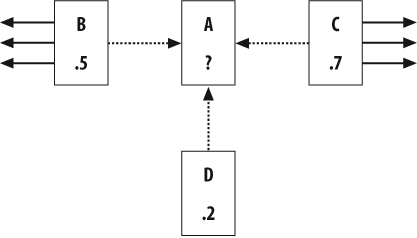

Теоретически алгоритм PageRank рассчитывает вероятность того, что человек, случайно переходящий по ссылкам, доберется до некоторой страницы. Чем больше ссылок ведет на данную страницу с других популярных страниц, тем выше вероятность, что на неё перейдут. В алгоритм PageRank введен коэффициент затухания 0,85, означающий, что пользователь продолжит переходить по ссылкам, имеющимся на текущей странице, с вероятностью 0,85. Также для любой страницы вводится минимальная величина 0,15.

$$PageRank(A) = 0,15 + 0,85 * (PR(B)/linksfrom(B) + PR(C)/linksfrom(C) + PR(D)/linksfrom(D))$$




В этом примере для всех страниц, ссылающихся на A, уже был вычислен ранг. Но невозможно вычислить ранг страницы, пока неизвестны ранги ссылающихся на нее страниц, а эти ранги можно вычислить, только зная ранги страницы, которые ссылаются на них. Но это проблема только для первого раза.

Решение состоит в том, чтобы присвоить всем страницам произвольный начальный ранг (величина несущественна но число должно быть строго больше 0 и не больше 1) и провести несколько итераций. После каждой итерации ранг каждой страницы будет все ближе к истинному значению PageRank. Условия остановки: максимальное количество итераций или PageRank перестал изменяться.

In [ ]:
def calculatepagerank(iterations=10):
    # удалим таблицу, если она есть
    # con.execute('drop table if exists pagerank')
    con.execute('create table pagerank(urlid primary key,score)')

    # инициализируем PR для каждого url
    con.execute('insert into pagerank select rowid, 1.0 from urllist')
    con.commit()

    for i in range(iterations):
      print ("Iteration %d" % (i))
      for (urlid,) in con.execute('select rowid from urllist'):
        pr=0.15

        # пройдёмся по всем страницам, которые ссылаются на страницу
        for (linker,) in con.execute('select distinct fromid from link where toid=%d' % urlid):
          # получим PR ссылающейся страницы
          linkingpr=con.execute('select score from pagerank where urlid=%d' % linker).fetchone(  )[0]

          # посчитаем общее количество ссылок на ссылающейся странице
          linkingcount=con.execute('select count(*) from link where fromid=%d' % linker).fetchone()[0]
          pr+=0.85*(linkingpr/linkingcount)
        con.execute('update pagerank set score=%f where urlid=%d' % (pr,urlid))
      con.commit()

In [ ]:
calculatepagerank()

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


In [ ]:
cur = con.execute('select * from pagerank order by score desc')

In [ ]:
[row for row in con.execute('select * from pagerank order by score desc')]

[(2, 0.155085),
 (3, 0.155085),
 (4, 0.155085),
 (5, 0.155085),
 (6, 0.155085),
 (7, 0.155085),
 (8, 0.155085),
 (9, 0.155085),
 (10, 0.155085),
 (11, 0.155085),
 (12, 0.155085),
 (13, 0.155085),
 (14, 0.155085),
 (15, 0.155085),
 (16, 0.155085),
 (17, 0.155085),
 (18, 0.155085),
 (19, 0.155085),
 (20, 0.155085),
 (21, 0.155085),
 (22, 0.155085),
 (23, 0.155085),
 (25, 0.155085),
 (26, 0.155085),
 (27, 0.155085),
 (28, 0.155085),
 (29, 0.155085),
 (30, 0.155085),
 (31, 0.155085),
 (32, 0.155085),
 (33, 0.155085),
 (34, 0.155085),
 (35, 0.155085),
 (36, 0.155085),
 (37, 0.155085),
 (38, 0.155085),
 (39, 0.155085),
 (40, 0.155085),
 (41, 0.155085),
 (42, 0.155085),
 (1, 0.152542),
 (24, 0.152542)]

Понятно, что на таком наборе результат совсем не показательный. Ведь у нас собраны только ссылки с двух страниц, и именно эти страницы оказались в самом низу. 